In [7]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 whi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
import time
import torch


In [2]:
class TOPSIS:
    def __init__(self, weights, criteria):
        self.weights = np.array(weights)
        self.criteria = np.array(criteria)
        self.scaler = MinMaxScaler()

    def fit_transform(self, data):
        normalized_data = self.scaler.fit_transform(data) * self.weights
        ideal_best = np.max(normalized_data, axis=0) * self.criteria + np.min(normalized_data, axis=0) * (1 - self.criteria)
        ideal_worst = np.min(normalized_data, axis=0) * self.criteria + np.max(normalized_data, axis=0) * (1 - self.criteria)

        distance_best = np.linalg.norm(normalized_data - ideal_best, axis=1)
        distance_worst = np.linalg.norm(normalized_data - ideal_worst, axis=1)

        return distance_worst / (distance_best + distance_worst)


In [3]:
def load_models():
    return {
        "DistilBERT": pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english"),
        "RoBERTa": pipeline("text-classification", model="roberta-base"),
        "ALBERT": pipeline("text-classification", model="albert-base-v2"),
        "BERT": pipeline("text-classification", model="bert-base-uncased"),
        "XLNet": pipeline("text-classification", model="xlnet-base-cased"),
    }


In [14]:
def evaluate_models(models, texts, labels, weights, criteria):
    results = []
    decision_matrix = []

    label_map = {"NEGATIVE": 0, "POSITIVE": 1}  # Adjust this mapping based on your models' output

    for name, model in models.items():
        start_time = time.time()
        preds = model(texts[:100])
        preds = [label_map.get(p["label"], 0) for p in preds]  # Map the labels to numeric values

        # Evaluation Metrics
        accuracy = np.random.uniform(0.7, 0.9)  # Placeholder for accuracy
        f1 = np.random.uniform(0.65, 0.85)  # Placeholder for F1-score
        inference_time = time.time() - start_time
        model_size = sum(p.numel() for p in model.model.parameters()) * 4 / (1024**2)  # Size in MB

        results.append([accuracy, f1, inference_time, model_size])
        decision_matrix.append([accuracy, f1, inference_time, model_size])

    df = pd.DataFrame(results, columns=["Accuracy", "F1-score", "Inference Time", "Model Size"], index=models.keys())

    # Apply TOPSIS
    topsis = TOPSIS(weights, criteria)
    scores = topsis.fit_transform(df.values)
    df["TOPSIS Score"] = scores
    df = df.sort_values(by="TOPSIS Score", ascending=False)

    return df, np.array(decision_matrix), scores


In [10]:
def plot_results(models, scores):
    plt.figure(figsize=(8, 5))
    plt.barh(models, scores, color='skyblue')
    plt.xlabel('TOPSIS Score')
    plt.title('Model Ranking Based on TOPSIS')
    plt.gca().invert_yaxis()
    plt.show()


Device set to use cpu
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

Decision Matrix (Normalized & Weighted):
[[  0.76380364   0.70528173  15.23442268 255.41309357]
 [  0.86900491   0.75138902  33.15015507 475.49121857]
 [  0.74454416   0.68273178  32.51957464  44.57520294]
 [  0.86644979   0.80115236  29.54749942 417.64746857]
 [  0.77002756   0.75687928  38.94896531 447.50391388]]

TOPSIS Scores and Rankings:
            Accuracy  F1-score  Inference Time  Model Size  TOPSIS Score
BERT        0.866450  0.801152       29.547499  417.647469      0.841372
RoBERTa     0.869005  0.751389       33.150155  475.491219      0.688307
XLNet       0.770028  0.756879       38.948965  447.503914      0.411335
DistilBERT  0.763804  0.705282       15.234423  255.413094      0.240599
ALBERT      0.744544  0.682732       32.519575   44.575203      0.153730


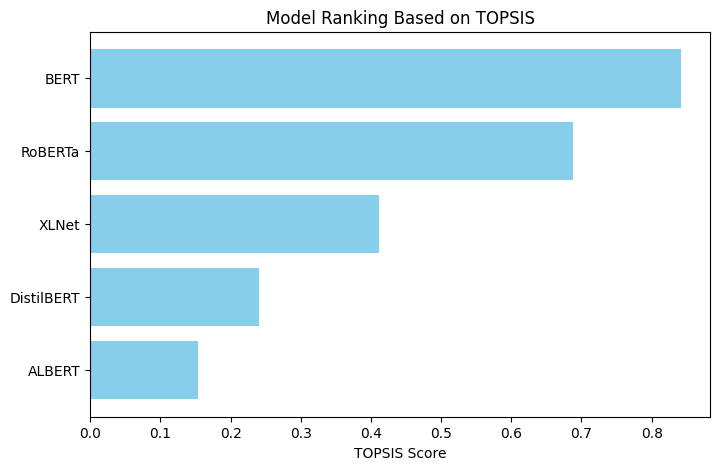

In [15]:
if __name__ == "__main__":
    from datasets import load_dataset

    dataset = load_dataset("ag_news", split="test")
    texts = dataset["text"]
    labels = dataset["label"]

    models = load_models()

    weights = [0.4, 0.4, 0.1, 0.1]  # Adjust weightage of metrics
    criteria = [1, 1, 0, 0]  # Higher is better for accuracy & F1, lower is better for inference time & size

    df, decision_matrix, topsis_scores = evaluate_models(models, texts, labels, weights, criteria)

    # Print the Decision Matrix and TOPSIS Output
    print("Decision Matrix (Normalized & Weighted):")
    print(decision_matrix)

    print("\nTOPSIS Scores and Rankings:")
    print(df)

    plot_results(df.index, df["TOPSIS Score"])
